In [1]:
import pandas as pd
%pylab inline
%load_ext autoreload
%autoreload 2
#%matplotlib nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

from UKMovementSensing import hsmm

In [3]:
datadir = "/media/sf_VBox_Shared/London/accelerometer_5second/merged/"
path_to_file5sec = os.path.join(datadir, "__016563_2014-08-08 12-02-19.bin_day1.csv")

In [4]:
filenames = os.listdir(datadir)
datasets = [pd.read_csv(os.path.join(datadir,fn)) for fn in filenames]
print(len(datasets))

21


In [5]:
for i in range(len(datasets)):
    datasets[i] = datasets[i].set_index('timestamp')
    datasets[i].index = pd.to_datetime(datasets[i].index) 
    datasets[i]['Activity'] = [str(a) for a in datasets[i]['Activity']]

In [6]:
example_index = 2
day1_5sec = datasets[example_index]

print(min(day1_5sec.index))
print(max(day1_5sec.index))

2014-08-02 04:00:00
2014-08-03 03:59:55


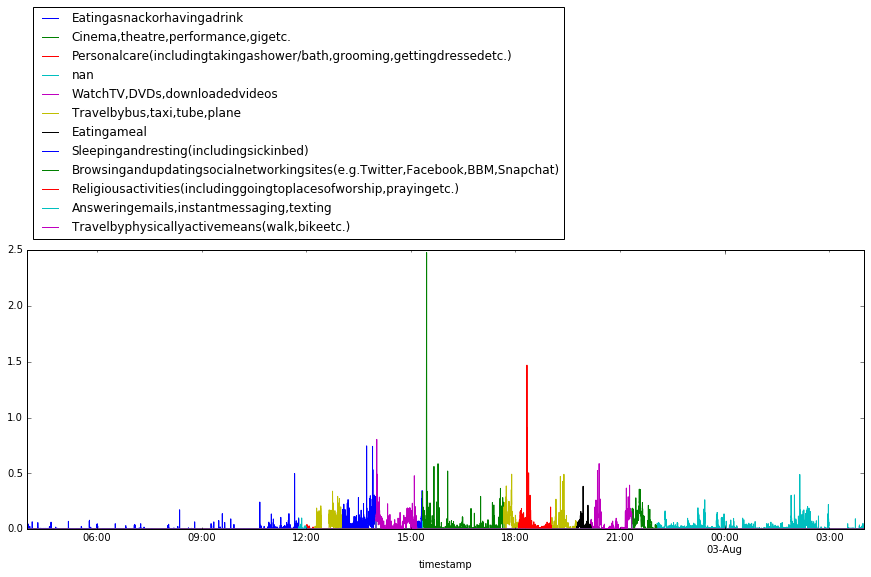

In [7]:
#byAct = day1_5sec.groupby('Activity')
activities = set(day1_5sec['Activity'])
fig, ax = plt.subplots(figsize=(15,5))
for act in activities:
    dfa = day1_5sec.copy()
    dfa[dfa['Activity']!=act] = 0
    dfa['acceleration'].plot(label=act)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3);

In [8]:
X_list = [np.column_stack([d.anglex, d.angley, d.anglez]) for d in datasets] #, day1_5sec.acceleration])
column_names = ['anglex', 'angley', 'anglez', 'acceleration']
print(column_names)

['anglex', 'angley', 'anglez', 'acceleration']


In [9]:
X = X_list[example_index]
print(X.shape)

(17280, 3)


## Create and train the model

In [10]:
Nmax = 7
dim = X.shape[1]

/home/dafne/anaconda2/envs/ucl2/lib/python2.7/site-packages/pybasicbayes/util/stats.py:185: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)


0
Resampled 21 sequences in 89.6 seconds
1
Resampled 21 sequences in 86.5 seconds
2
Resampled 21 sequences in 84.4 seconds
3
Resampled 21 sequences in 80.4 seconds
4
Resampled 21 sequences in 78.3 seconds


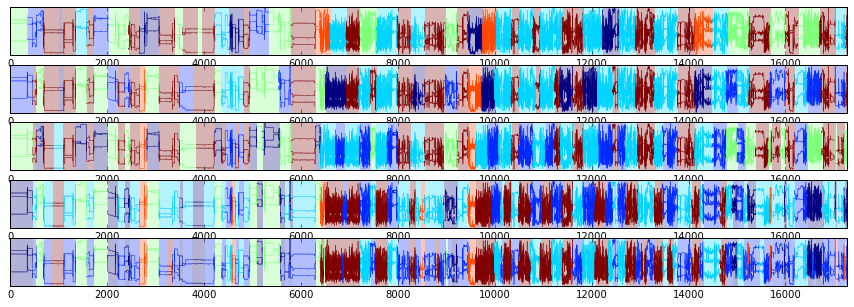

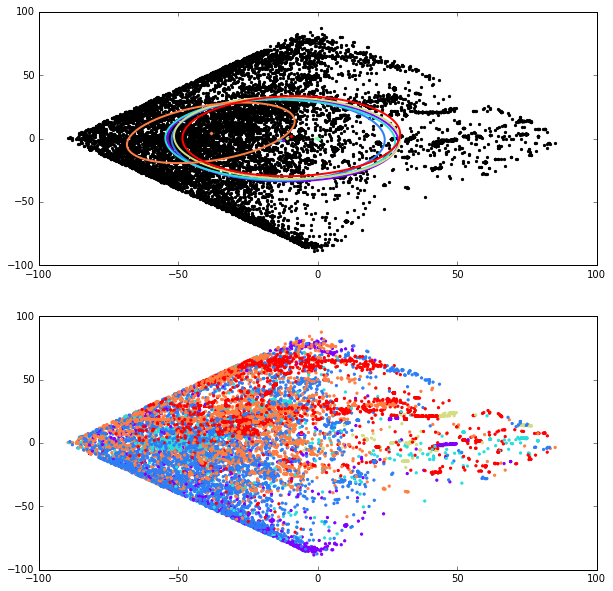

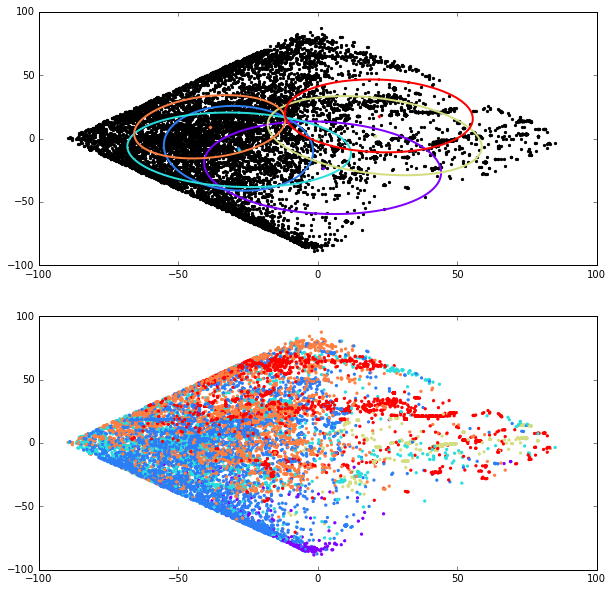

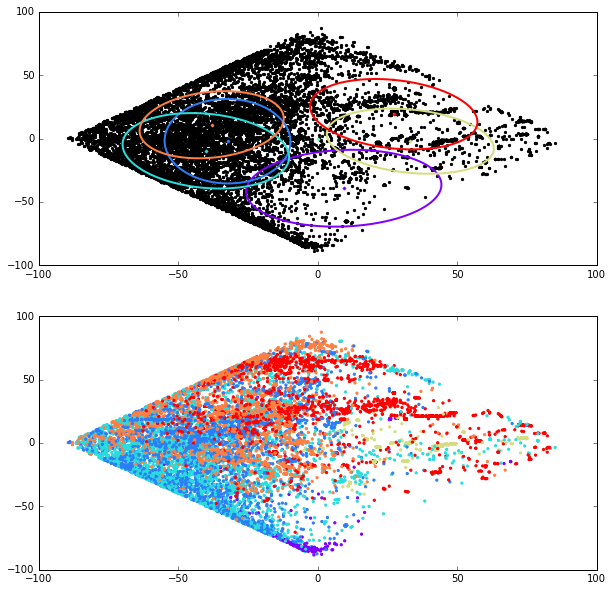

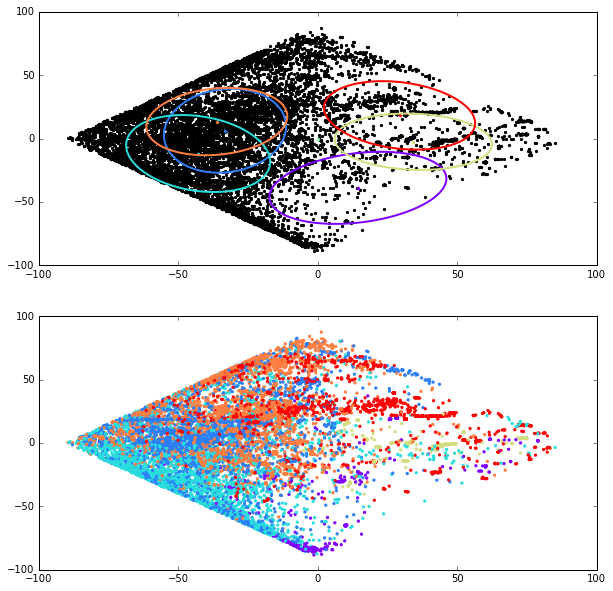

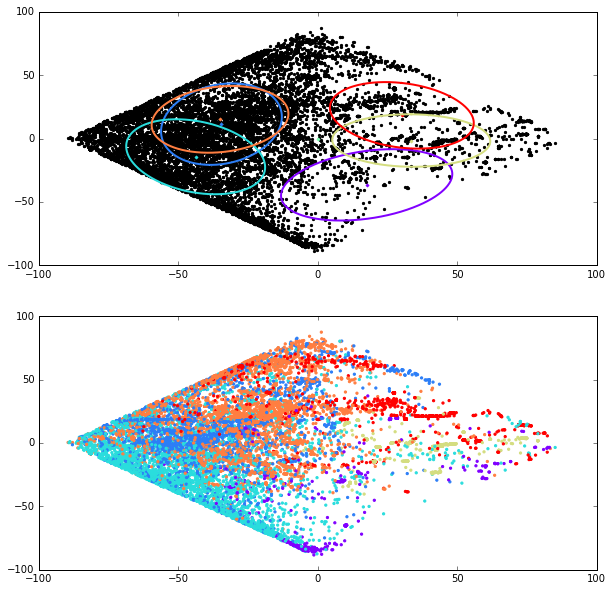

In [80]:
model, model_dist = hsmm.train_hsmm(X_list, Nmax=Nmax, nr_resamples=5, trunc=600, visualize=True)

In [90]:
d_old = model_dist[0]
for d in model_dist:
    #print d[0].mu
    diff = np.array([np.sqrt(np.sum(np.square(d[i].mu - d_old[i].mu))) for i in range(len(d))])
    print np.mean(diff)
    d_old = d

0.0
20.4543669048
10.6964534834
6.43176579006
3.24406920211


In [91]:
data = day1_5sec
hidden_states = model.stateseqs[example_index]

In [92]:
colormap, cmap = hsmm.get_color_map(Nmax)

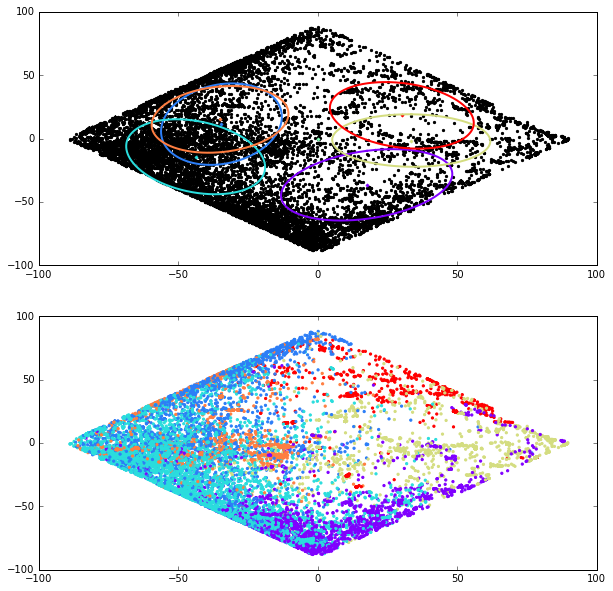

In [93]:
hsmm.plot_observations(X, 0, 1, model, hidden_states, num_states)

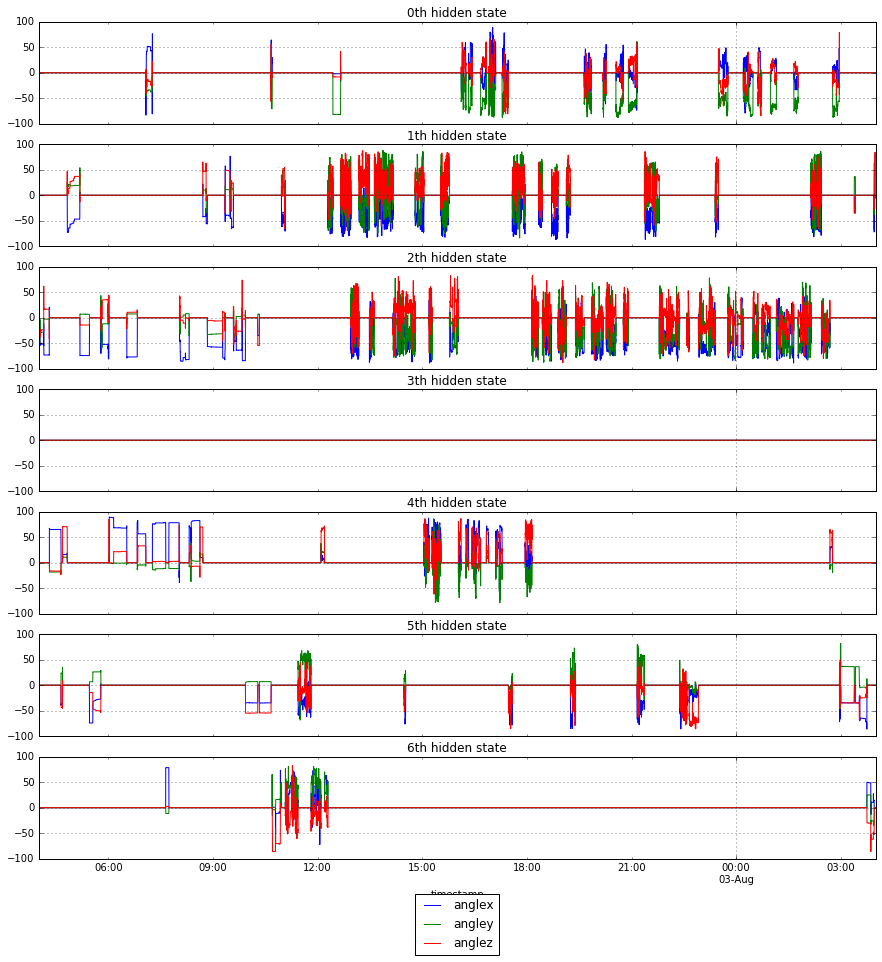

In [94]:
hsmm.plot_perstate(data[['anglex', 'angley', 'anglez']], hidden_states)

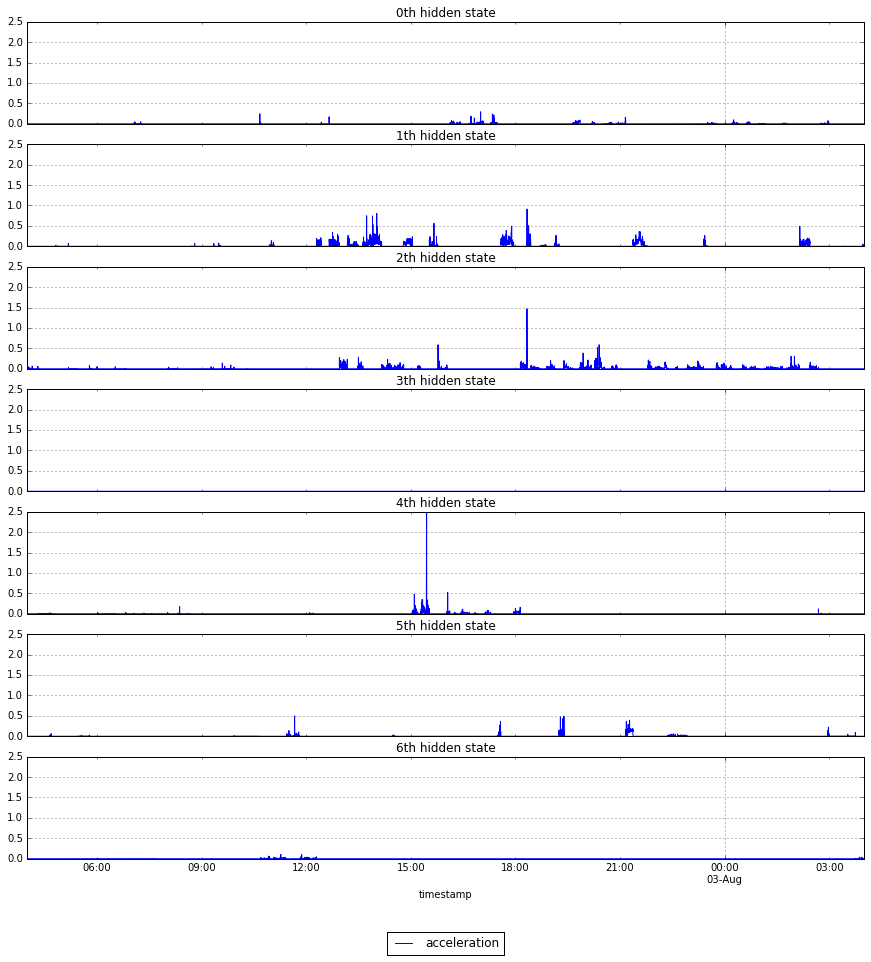

In [95]:
hsmm.plot_perstate(data[['acceleration']], hidden_states)

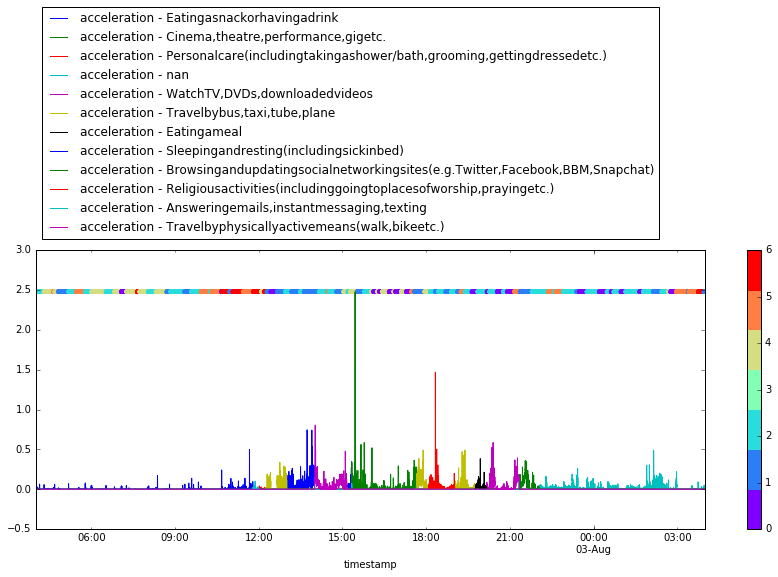

In [96]:
hsmm.plot_states_and_var(data, hidden_states, columns=['acceleration'], by='Activity')

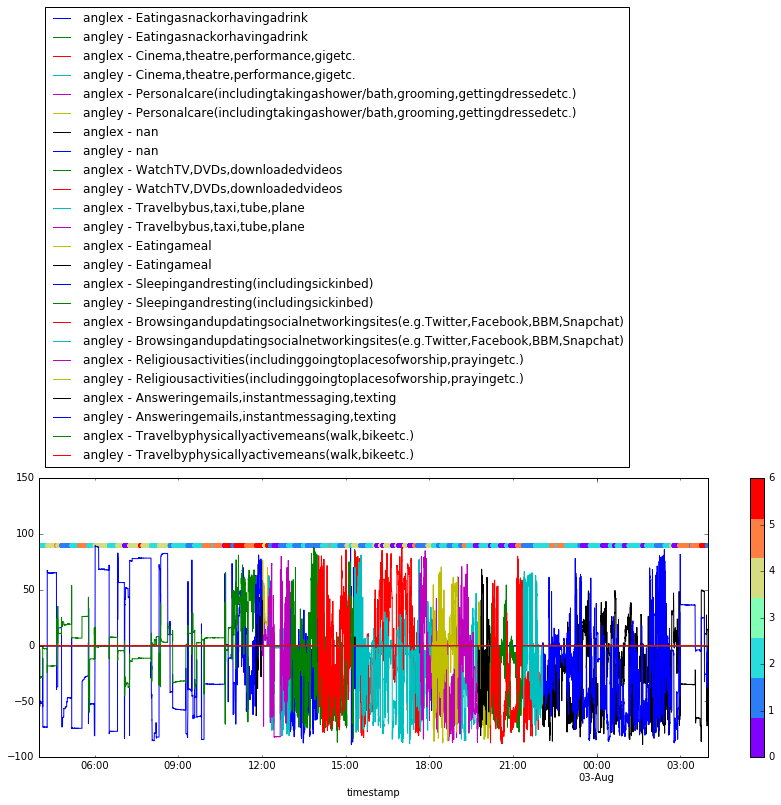

In [97]:
hsmm.plot_states_and_var(data, hidden_states, columns=['anglex', 'angley'], by='Activity')

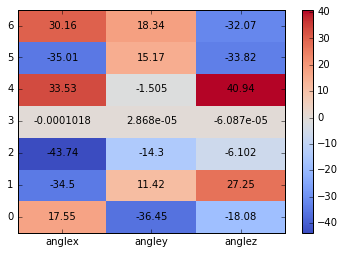

In [98]:
#Plot the means
plotdata = np.array([d.mu for d in model.obs_distns])

hsmm.plot_heatmap(plotdata, horizontal_labels=column_names)

In [99]:
#Plot the mean of the acceleration
#plotdata2 = plotdata[:,3][:,np.newaxis]
#hsmm.plot_heatmap(plotdata2, column_names)

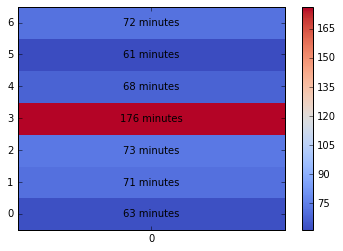

In [100]:
# Plot expected duration
plotdata = np.array([d.lmbda/3. for d in model.dur_distns])[:,np.newaxis]
#grouplabels = ["{:.3} minutes".format(x/3.) for x in plotdata[:,0]]
hsmm.plot_heatmap(plotdata, form='{:.0f} minutes')

Plot the covariance matrix for each state

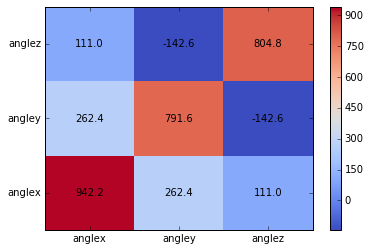

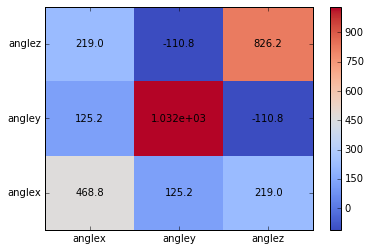

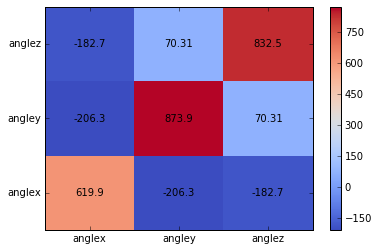

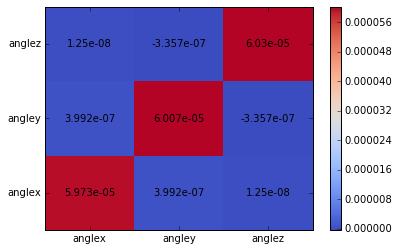

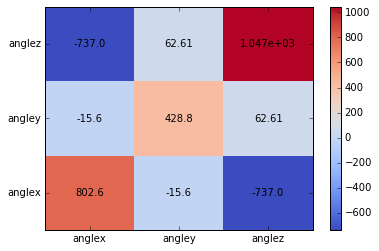

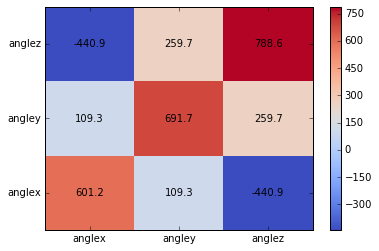

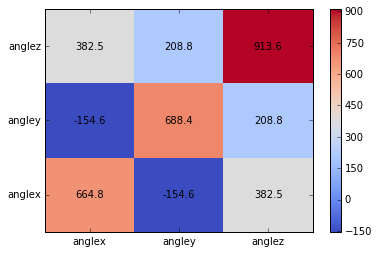

In [101]:
#fig, axs = plt.subplots(nrows=model.num_states, ncols=1,  figsize = (10, 15))
for i in range(model.num_states):
    plotdata = model.obs_distns[i].sigma
    #plt.sca(axs[i])
    hsmm.plot_heatmap(plotdata, horizontal_labels=column_names, vertical_labels=column_names)
#colorbar()
show()

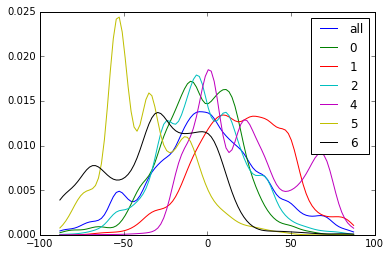

In [102]:
from scipy.stats.kde import gaussian_kde

variable = "anglez"#"acceleration"

fig, ax = subplots()
#day1_5sec.hist(variable, bins=100)
vals = data[variable]
kde = gaussian_kde(vals)
d = np.linspace(min(vals), max(vals), 100)
p = plot(d, kde(d), label="all")

for i in range(model.num_states):
    mask = hidden_states == i
    if(sum(mask)>0):
        kde = gaussian_kde(vals[mask])
        plot(d, kde(d), label=str(i))
#ax.set_xlim(0,0.1)
legend()
show()

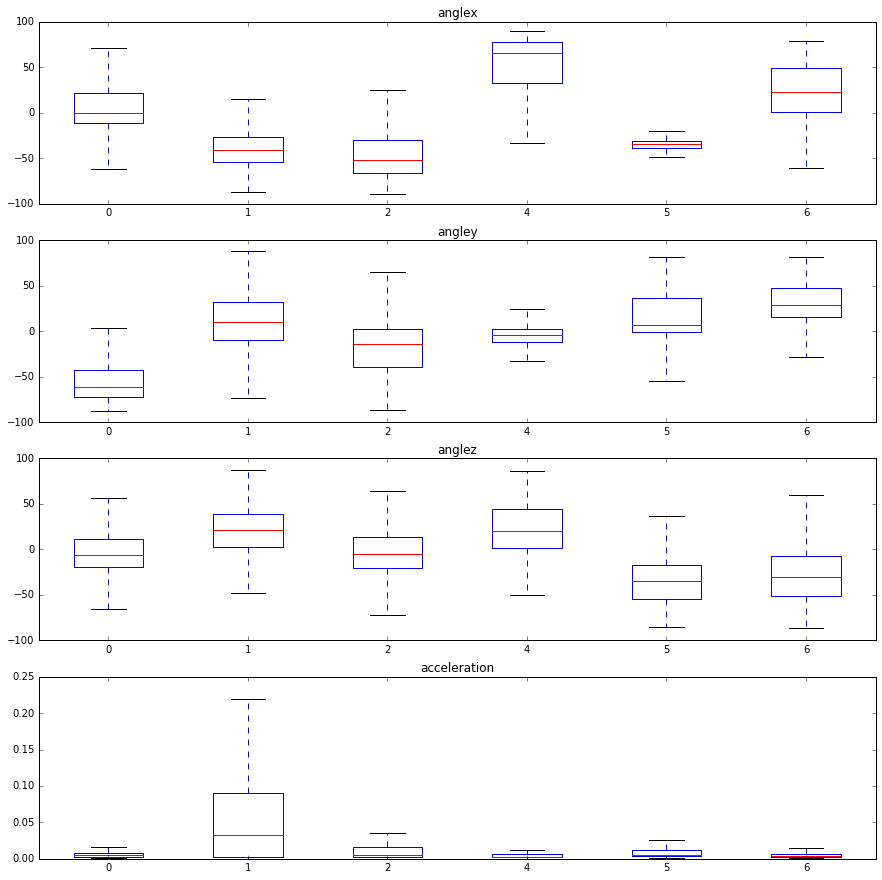

In [103]:
hsmm.plot_boxplots(data[column_names], hidden_states)

In [104]:
def getDurations(hidden_states, nr_states):
    durations = {i: [] for i in range(nr_states)}
    prev = hidden_states[0]
    d = 0
    for x in hidden_states:
        if x == prev:
            d += 1
        else:
            durations[prev].append(d)
            prev = x
            d = 0
    return durations

In [113]:
durations = getDurations(hidden_states, num_states)
for i, d in durations.iteritems():
    if len(d)>0:
        datdur = np.mean(d)
        distdur = model.dur_distns[i].lmbda
        print('{}\t{:.1f}\t{:.1f}'.format(i, datdur, distdur))
    else:
        print(i)

0	124.6	187.6
1	168.7	213.3
2	200.1	220.3
3
4	156.4	202.6
5	174.5	184.2
6	156.5	214.8


In [110]:
durations[3]

[]